In [1]:
# import rasterio as rio
import matplotlib.pyplot as plt 
from matplotlib.colors import Normalize
import numpy as np
import numpy.matlib
from scipy import interpolate
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import scipy
import os, sys, pickle, gzip
import datetime
# import geopy.distance
import xarray as xr
import pandas as pd
# import geopandas as gpd
import shapely.geometry
import shapely.ops
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import itertools
import random
import glob
import xesmf as xe
# import metpy
# from metpy.plots import USCOUNTIES
# from pyts.decomposition import SingularSpectrumAnalysis

import warnings
warnings.filterwarnings('ignore')

In [2]:
run ../util/setupConsole_su

In [3]:
# dataDir = '/dartfs-hpc/rc/lab/C/CMIG/ecoffel/data/projects/ag6'
dataDir = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag6'
dirDeepak = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate/deepak/Maize_yield_1970_2013'

In [4]:
crop_models = ['CLM-Crop.Maize', 'EPIC-Boku.Maize', 'EPIC-IIASA.Maize', 'EPIC-TAMU.Maize', 'GEPIC.Maize', 'LPJ-GUESS.Maize', 'LPJmL.Maize', \
              'pAPSIM.Maize', 'pDSSAT.Maize', 'PEGASUS.Maize', 'PEPIC.Maize', 'PRYSBI2.Maize']

In [5]:
latRange = [-90, 90]
lonRange = [0, 360]
regridMesh = xr.Dataset({'lat': (['lat'], np.arange(latRange[0], latRange[1], .5)),
                         'lon': (['lon'], np.arange(lonRange[0], lonRange[1], .5)),})

In [6]:
agmip_yield = xr.Dataset()

In [7]:
model_var = 'yield_mai'
wx_data = 'agmerra'

agmip_yield_da = xr.DataArray()

for i, model in enumerate(crop_models):
    
    # find current model file name
    fname = glob.glob('%s/agmip/%s/%s/*_hist_default_noirr_%s_annual_1980_2010.nc4'%(dataDir, model, wx_data, model_var))
    
    if len(fname) == 0:
        continue
    
    print('opening %s...'%model)
    cur_mdl_yield = xr.open_dataset(fname[0], decode_times=False)
    
    cur_mdl_yield.roll(lon=round(cur_mdl_yield.lon.size/2))
    
    print('loading %s...'%model)
    cur_mdl_yield.load()
    
    print('regridding %s...'%model)
    regridder = xe.Regridder(cur_mdl_yield, regridMesh, 'bilinear')
    regridder.clean_weight_file()
    cur_mdl_yield_regrid = regridder(cur_mdl_yield[model_var])
    
    if i == 0:
        timeVar = cur_mdl_yield.time
    
    cur_mdl_yield_regrid_4d = np.full([1, cur_mdl_yield_regrid.shape[0], cur_mdl_yield_regrid.shape[1], cur_mdl_yield_regrid.shape[2]], np.nan)
    cur_mdl_yield_regrid_4d[0, :, :, :] = cur_mdl_yield_regrid
    tempDs_yield = xr.DataArray(data = cur_mdl_yield_regrid_4d,
                          dims   = ['model', 'time', 'lat', 'lon'],
                          coords = {'model':[crop_models[i]], 'time': timeVar, 'lat':regridMesh['lat'], 'lon':regridMesh['lon']})
    if i == 0:
        agmip_yield_da = tempDs_yield
    else:
        agmip_yield_da = xr.concat([agmip_yield_da, tempDs_yield], dim='model')
    
    print()
agmip_yield[model_var] = agmip_yield_da
agmip_yield.to_netcdf('agmip_default_noirr_%s.nc'%model_var)
# cmip6_txx_ds.to_netcdf('cmip6_txx_us.nc')
# cmip6_t50p_ds.to_netcdf('cmip6_t50p_us.nc')
# cmip6_monthly_mean_tx_ds.to_netcdf('cmip6_monthly_mean_tx_us.nc')

opening CLM-Crop.Maize...
loading CLM-Crop.Maize...
regridding CLM-Crop.Maize...
Create weight file: bilinear_360x720_360x720.nc
Remove file bilinear_360x720_360x720.nc

opening EPIC-Boku.Maize...
loading EPIC-Boku.Maize...
regridding EPIC-Boku.Maize...
Create weight file: bilinear_360x720_360x720.nc
Remove file bilinear_360x720_360x720.nc

opening EPIC-IIASA.Maize...
loading EPIC-IIASA.Maize...
regridding EPIC-IIASA.Maize...
Create weight file: bilinear_360x720_360x720.nc
Remove file bilinear_360x720_360x720.nc

opening GEPIC.Maize...
loading GEPIC.Maize...
regridding GEPIC.Maize...
Create weight file: bilinear_360x720_360x720.nc
Remove file bilinear_360x720_360x720.nc

opening LPJ-GUESS.Maize...
loading LPJ-GUESS.Maize...
regridding LPJ-GUESS.Maize...
Create weight file: bilinear_360x720_360x720.nc
Remove file bilinear_360x720_360x720.nc

opening LPJmL.Maize...
loading LPJmL.Maize...
regridding LPJmL.Maize...
Create weight file: bilinear_360x720_360x720.nc
Remove file bilinear_360x72

In [6]:
agmip_yield = xr.open_dataset('agmip_default_noirr_%s.nc'%model_var, decode_times=False)
agmip_yield_midwest = agmip_yield.sel(lat=slice(30,45), lon=slice(250, 275))

NameError: name 'model_var' is not defined

In [11]:
agmip_yield_midwest

<xarray.Dataset>
Dimensions:    (lat: 31, lon: 51, model: 10, time: 31)
Coordinates:
  * model      (model) object 'CLM-Crop.Maize' ... 'PEPIC.Maize'
  * time       (time) float32 1.0 2.0 3.0 4.0 5.0 ... 27.0 28.0 29.0 30.0 31.0
  * lat        (lat) float64 30.0 30.5 31.0 31.5 32.0 ... 43.5 44.0 44.5 45.0
  * lon        (lon) float64 250.0 250.5 251.0 251.5 ... 273.5 274.0 274.5 275.0
Data variables:
    yield_mai  (model, time, lat, lon) float64 ...

In [12]:
for m in range(agmip_yield_midwest.yield_mai.shape[0]):
    X = sm.add_constant(range(agmip_yield_midwest.yield_mai.shape[1]))
    mdl = sm.OLS(np.nanmean(np.nanmean(agmip_yield_midwest.yield_mai[m,:,:,:], axis=2), axis=1), X).fit()
    print(mdl.params, mdl.pvalues[1])


[5.48839602 0.0120393 ] 0.29760281676428346
[6.41369217 0.01239237] 0.4681760131158744
[5.14634748e+00 2.34844518e-03] 0.8110682505477259
[4.79972791e+00 1.70947403e-03] 0.9022504496479584
[ 2.75651938e+00 -5.63486775e-04] 0.9158046218695738
[4.09260807 0.01429211] 0.3668534598678591
[4.16356772 0.0078848 ] 0.567471677733638
[7.06508523e+00 2.13320118e-03] 0.9041047799351385
[6.97168343 0.0192137 ] 0.26314045641345835
[ 6.46486632 -0.01441641] 0.37131694389934256


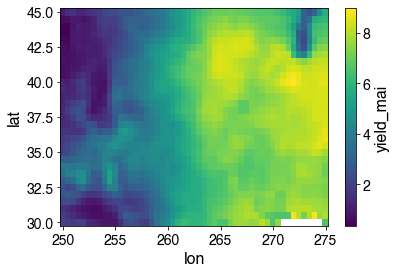

In [14]:
agmip_yield_midwest.yield_mai.mean(dim='time').mean(dim='model').plot()

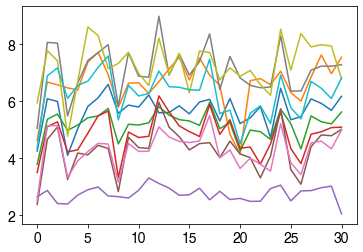

In [15]:
plt.plot(np.nanmean(np.nanmean(agmip_yield_midwest.yield_mai[:,:,:,:], axis=3), axis=2).T)

In [16]:
# load deepak data
maize_yield_deepak_ds = xr.Dataset()
for y, year in enumerate(range(1980, 2013+1)):
    print('processing deepak for %d...'%year)
    cur_maize_yield_deepak_ds = xr.open_dataset('%s/Maize_areaweightedyield_%d_ver12b.nc'%(dirDeepak, year))
    
    lonvals = cur_maize_yield_deepak_ds['longitude'].values
    lonvals[lonvals < 0] = 360+lonvals[lonvals < 0]
    cur_maize_yield_deepak_ds['longitude'] = lonvals
    
    latvals = cur_maize_yield_deepak_ds['latitude'].values
    cur_maize_yield_deepak_ds['latitude'] = latvals
    
    cur_maize_yield_deepak_ds = cur_maize_yield_deepak_ds.rename(latitude='lat', longitude='lon')
    
    cur_maize_yield_deepak_ds.load()
    
    regridder = xe.Regridder(cur_maize_yield_deepak_ds, regridMesh, 'bilinear')
    regridder.clean_weight_file()
    cur_maize_yield_deepak_ds_regrid = regridder(cur_maize_yield_deepak_ds.Data)

    tempDs_maize_yield = xr.Dataset()
    tempDs_maize_yield['maize_yield'] = xr.DataArray(data = np.squeeze(cur_maize_yield_deepak_ds_regrid.values, axis=1), 
                          dims   = ['time', 'lat', 'lon'],
                          coords = {'time':[datetime.datetime(year,1,1)], 'lat':regridMesh['lat'], 'lon':regridMesh['lon']},
                          attrs  = {'units'     : 't/ha'
                            })
    
    if y == 0:
        maize_yield_deepak_ds = tempDs_maize_yield
    else:
        maize_yield_deepak_ds = xr.concat([maize_yield_deepak_ds, tempDs_maize_yield], dim='time')
maize_yield_deepak_ds.to_netcdf('maize_yield_deepak.nc')

processing deepak for 1980...
Create weight file: bilinear_360x720_360x720.nc
Remove file bilinear_360x720_360x720.nc
processing deepak for 1981...
Create weight file: bilinear_360x720_360x720.nc
Remove file bilinear_360x720_360x720.nc
processing deepak for 1982...
Create weight file: bilinear_360x720_360x720.nc
Remove file bilinear_360x720_360x720.nc
processing deepak for 1983...
Create weight file: bilinear_360x720_360x720.nc
Remove file bilinear_360x720_360x720.nc
processing deepak for 1984...
Create weight file: bilinear_360x720_360x720.nc
Remove file bilinear_360x720_360x720.nc
processing deepak for 1985...
Create weight file: bilinear_360x720_360x720.nc
Remove file bilinear_360x720_360x720.nc
processing deepak for 1986...
Create weight file: bilinear_360x720_360x720.nc
Remove file bilinear_360x720_360x720.nc
processing deepak for 1987...
Create weight file: bilinear_360x720_360x720.nc
Remove file bilinear_360x720_360x720.nc
processing deepak for 1988...
Create weight file: biline

In [17]:
maize_yield_deepak_ds = xr.open_dataset('maize_yield_deepak.nc')
deepak_yield_midwest = maize_yield_deepak_ds.sel(lat=slice(30,45), lon=slice(250, 275))

In [19]:
deepak_yield_midwest

<xarray.Dataset>
Dimensions:      (lat: 31, lon: 51, time: 34)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-01 1981-01-01 ... 2013-01-01
  * lat          (lat) float64 30.0 30.5 31.0 31.5 32.0 ... 43.5 44.0 44.5 45.0
  * lon          (lon) float64 250.0 250.5 251.0 251.5 ... 274.0 274.5 275.0
Data variables:
    maize_yield  (time, lat, lon) float64 1.456 1.297 1.088 ... nan nan 6.844

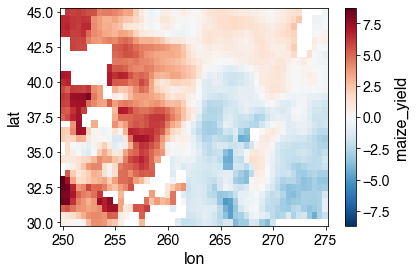

In [21]:
(deepak_yield_midwest.maize_yield.mean(dim='time')-np.nanmean(np.nanmean(agmip_yield_midwest.yield_mai,axis=1), axis=0)).plot()

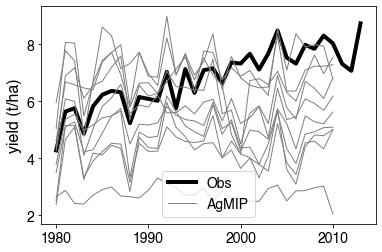

In [52]:
xyears = range(1980, 2014)
p1 = plt.plot(xyears, np.nanmean(np.nanmean(deepak_yield_midwest.maize_yield.values[:,:,:],axis=2), axis=1), '-k', lw=4, label='Obs')
p2 = plt.plot(xyears[:-3], np.nanmean(np.nanmean(agmip_yield_midwest.yield_mai[:,:,:,:], axis=3), axis=2).T, '-', color='gray', lw=1, label='AgMIP')
plt.ylabel('yield (t/ha)')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2], prop={'family':'Helvetica', 'size':14})
plt.savefig('obs-vs-agmip.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.02)

In [44]:
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

NameError: name 'ax' is not defined